In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/논문/Youtube-Recommendation/Movie-Lens

/content/drive/MyDrive/논문/Youtube-Recommendation/Movie-Lens


In [20]:
ls

 dataset.pkl
 logs/
 meta.tsv
 ml-100k/
 model.png
 MovieLens_Youtube_Recommendation_Candidate_Generation_Network.ipynb
 movielens.zip
 vecs.tsv
'Wine_Candidate_Rec_[Youtube_Recommendation_Candidate_Generation_Network].ipynb'


In [21]:
import os
import sys
import joblib
import numpy as n
import pandas as pd

In [22]:
data = joblib.load('./dataset.pkl')
locals().update(data)

In [23]:
train

,userID,wine_id,rating,enc_userID,enc_wine_id,recent,like,dislike
0,19484511,2532733,4.0,0,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]"
1,19484511,1253802,3.5,0,1,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]"
2,19484511,1123441,3.5,0,2,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]"
3,19484511,1157656,3.5,0,3,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]"
4,19484511,1134756,3.5,0,4,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[13, 20, 23, 25, 35, 38, 40, 41, 45, 46]","[6, 15, 28, 30, 31, 37, 61, 62, 67, 70]"
...,...,...,...,...,...,...,...,...
937751,16607503,1135203,3.5,6342,4672,"[1023, 14075, 3894, 4067]",[],[1023]
937752,16607503,4303173,3.0,6342,1023,"[14075, 3894, 4067]",[],[1023]
937753,16607503,2364090,4.0,6342,14075,"[3894, 4067]",[],[]
937754,16607503,1679387,3.5,6342,3894,[4067],[],[]


In [24]:
train = train.sample(frac = 1)

In [11]:
EMBEDDING_DIMS = 100
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES = 50861
LEARNING_RATE = 0.003

In [12]:
import tensorflow as tf
import keras
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

In [13]:
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask
    

In [16]:
#---inputs
import tensorflow as tf
import datetime
import os
input_recent = tf.keras.Input(shape=(None, ), name='recent')
inp_liked = tf.keras.layers.Input(shape=(None,), name='like')
inp_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
# input_profile = tf.keras.Input(shape=(, 4), name='profile')


#--- layers
# features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
#                                             mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim = NUM_CLASSES, output_dim = EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=256, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=128, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=64, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(1,
                                    #  activation=tf.nn.softmax,
                                     name='dense_output')

# --- features

# features_embeddings = features_embedding_layer(input_profile)
# l2_norm_features = l2_norm_1(features_embeddings)
# avg_features = avg_embeddings(l2_norm_features)

# dense_profile = tf.keras.layers.Dense(units = 16, name='dense_profile')
# dense_1_profile = dense_profile(input_profile)
# dense_1_profile_relu = tf.keras.layers.ReLU(name='dense_1_profile_relu')(dense_1_profile)



labels_liked_embeddings = labels_embedding_layer(inp_liked)
l2_norm_liked = l2_norm_1(labels_liked_embeddings)
avg_liked = avg_embeddings(l2_norm_liked)

labels_disliked_embeddings = labels_embedding_layer(inp_disliked)
l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
avg_disliked = avg_embeddings(l2_norm_disliked)

labels_genre_embeddings = labels_embedding_layer(input_recent)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_recent = avg_embeddings(l2_norm_genre)



concat_inputs = tf.keras.layers.Concatenate(axis=1)([
                                                    #  avg_features,
                                                    #  dense_1_profile_relu,
                                                     avg_liked,
                                                     avg_disliked,
                                                     avg_recent
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
#dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[
            # input_profile,
            inp_liked, 
            inp_disliked
            ,input_recent
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer = optimiser,
              loss='mean_squared_error',
              metrics=['mae', 'mse'])

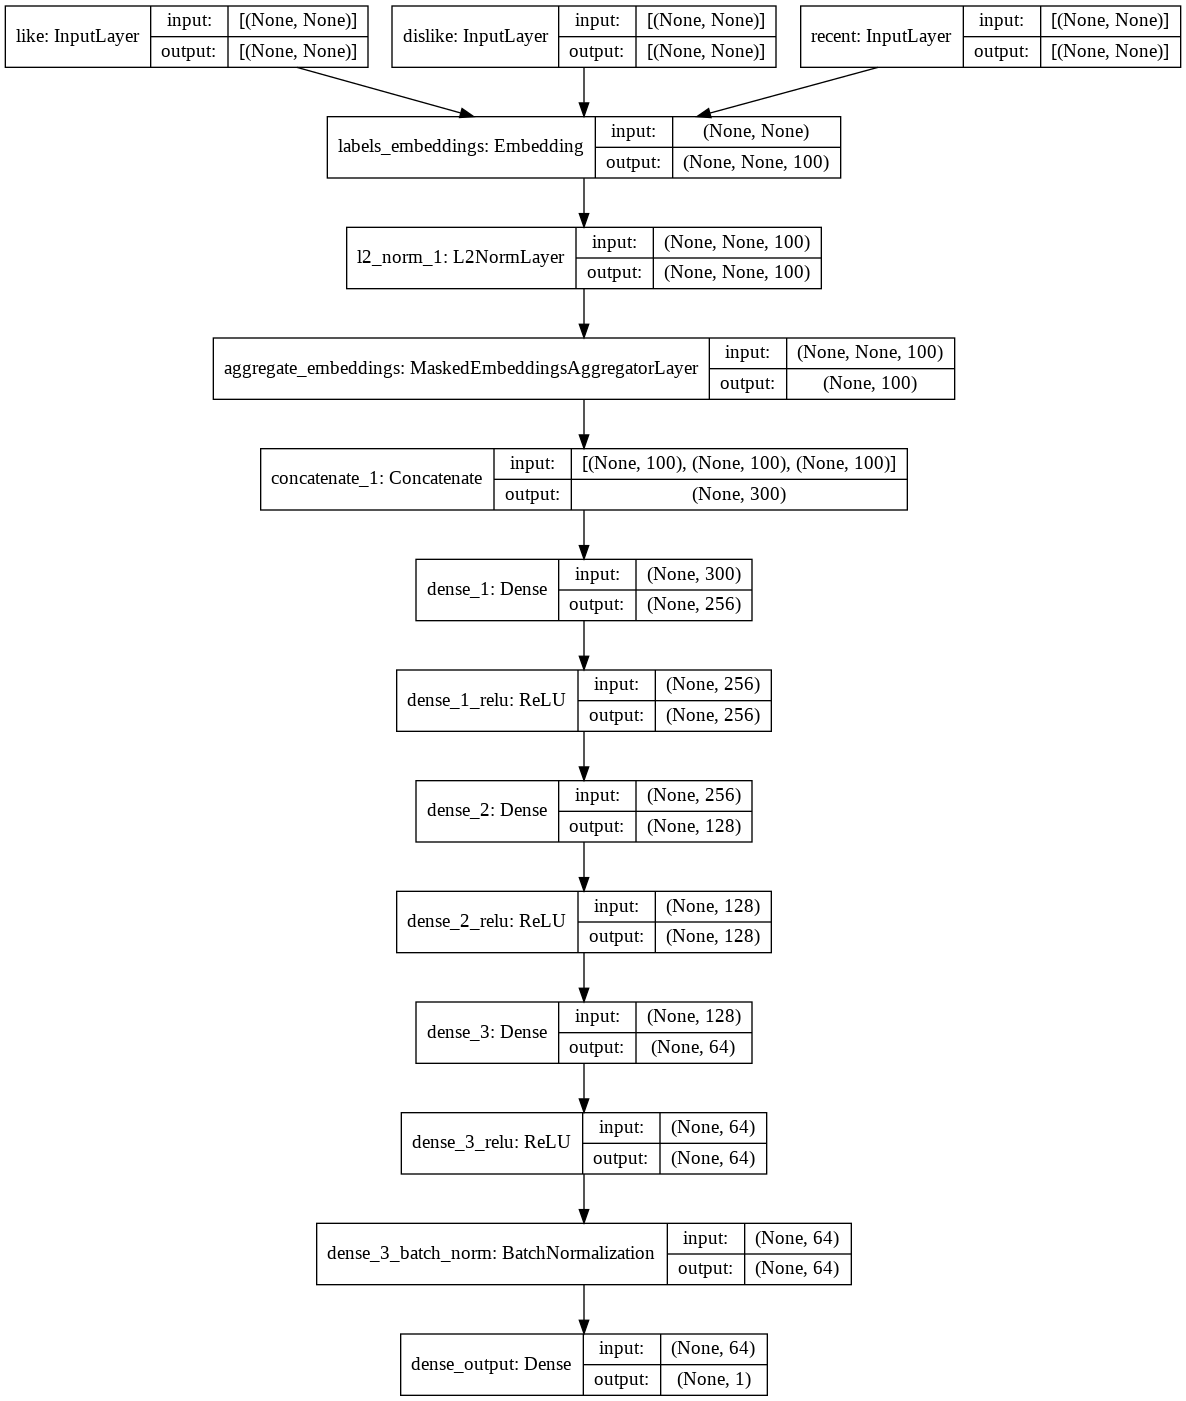

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [18]:
callbacks_list = [
                  keras.callbacks.EarlyStopping(
                    monitor = 'mse',
                    patience = 5
                  )
]

In [25]:
model.fit([
          #  tf.keras.preprocessing.sequence.pad_sequences(dataset['profile']),
           tf.keras.preprocessing.sequence.pad_sequences(train['like']),
           tf.keras.preprocessing.sequence.pad_sequences(train['dislike']),
           tf.keras.preprocessing.sequence.pad_sequences(train['recent'])
           ],
          train['rating'].values,
          # callbacks=[tensorboard_callback],
          batch_size = 1024,
          # steps_per_epoch = 1,
          epochs = 500,
          callbacks = callbacks_list,
          # validation_data = ([
          #                     tf.keras.preprocessing.sequence.pad_sequences(test['like']),
          #                     tf.keras.preprocessing.sequence.pad_sequences(test['dislike']),
          #                     tf.keras.preprocessing.sequence.pad_sequences(test['recent'])
          # ], test['rating'].values)
          )

Epoch 1/500
916/916 [==============================] - 72s 75ms/step - loss: 2.3180 - mae: 1.0077 - mse: 2.3180
Epoch 2/500
916/916 [==============================] - 68s 75ms/step - loss: 0.4521 - mae: 0.5078 - mse: 0.4521
Epoch 3/500
916/916 [==============================] - 68s 74ms/step - loss: 0.4517 - mae: 0.5077 - mse: 0.4517
Epoch 4/500
916/916 [==============================] - 67s 74ms/step - loss: 0.4524 - mae: 0.5081 - mse: 0.4524
Epoch 5/500
916/916 [==============================] - 67s 73ms/step - loss: 0.4521 - mae: 0.5071 - mse: 0.4521
Epoch 6/500
916/916 [==============================] - 67s 73ms/step - loss: 0.4535 - mae: 0.5082 - mse: 0.4535
Epoch 7/500
916/916 [==============================] - 67s 73ms/step - loss: 0.4524 - mae: 0.5079 - mse: 0.4524


In [32]:
predict = model.predict([
                        tf.keras.preprocessing.sequence.pad_sequences(train['like']),
                        tf.keras.preprocessing.sequence.pad_sequences(train['dislike']),
                        tf.keras.preprocessing.sequence.pad_sequences(train['recent'])
])
                                                                  

In [41]:
pd.Series([p[0] for p in predict]).value_counts()

3.926826    937756
dtype: int64

In [ ]:
predict = model.predict([
                        tf.keras.preprocessing.sequence.pad_sequences(test['like']),
                        tf.keras.preprocessing.sequence.pad_sequences(test['dislike']),
                        tf.keras.preprocessing.sequence.pad_sequences(test['recent')
])
                                                                  

In [ ]:
user_list_1=user_title_list[user_title_list.user>600]

In [ ]:
user_list_1.head(10)

In [ ]:
predict =model.predict([tf.keras.preprocessing.sequence.pad_sequences(user_list_1['title_d']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['like']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['dislike']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['all_genres'])
          ])


In [ ]:
import numpy as np

In [ ]:
predictions = np.array([np.argmax(a) for a in predict])
pd.DataFrame(predictions)

,0
0,602
1,602
2,602
3,602
4,602
5,602
6,602
7,602
8,602
9,602


In [ ]:
dataset2['label']

1        39572
3         6689
6        42949
9        33103
11        2694
         ...  
35747    30653
35786     5478
35792     7551
35793    28711
35796     5119
Name: label, Length: 6229, dtype: int64

NameError: ignored

In [ ]:
user_list_1['predicted_label'] = predictions

In [ ]:
user_list_1

In [ ]:
print(tf.argsort(predict,direction='DESCENDING',axis=-1))

In [ ]:
tf.nn.top_k(
    predict,
    k=20,
    sorted=True,
    name=None
)

In [ ]:
s=[i for i in range(len(movie2movie_encoded)) if movie2movie_encoded[i] == 365 ]

In [ ]:
movies[movies.movie_id == ''.join(str(s[0]))]

### Visualize Embeddings 

In [ ]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
#weights =model.layers[4].get_weights()[0]
weights = features_embedding_layer.get_weights()[0][1:]

for num, word in enumerate(title2title_encoded):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

NameError: ignored

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>